# K-means Project

### Importing Libraries

In [43]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Loading the dataset

In [2]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame

Since the link didn't work, I loaded the dataset manually.

In [3]:
# Keeping only desired columns
df = df[["Latitude", "Longitude", "MedInc"]]
df.head()

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462


In [4]:
print(f'Our dataframe contains {df.shape[0]} rows and it has {df.shape[1]} features.')

Our dataframe contains 20640 rows and it has 3 features.


### Identifying Duplicated and Null Values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   20640 non-null  float64
 1   Longitude  20640 non-null  float64
 2   MedInc     20640 non-null  float64
dtypes: float64(3)
memory usage: 483.9 KB


In [6]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [7]:
df.duplicated().sum()
df = df.drop_duplicates()

## Univariante Analysis

In [16]:
columns_list = df.columns.to_list()
columns_list

['Latitude', 'Longitude', 'MedInc']

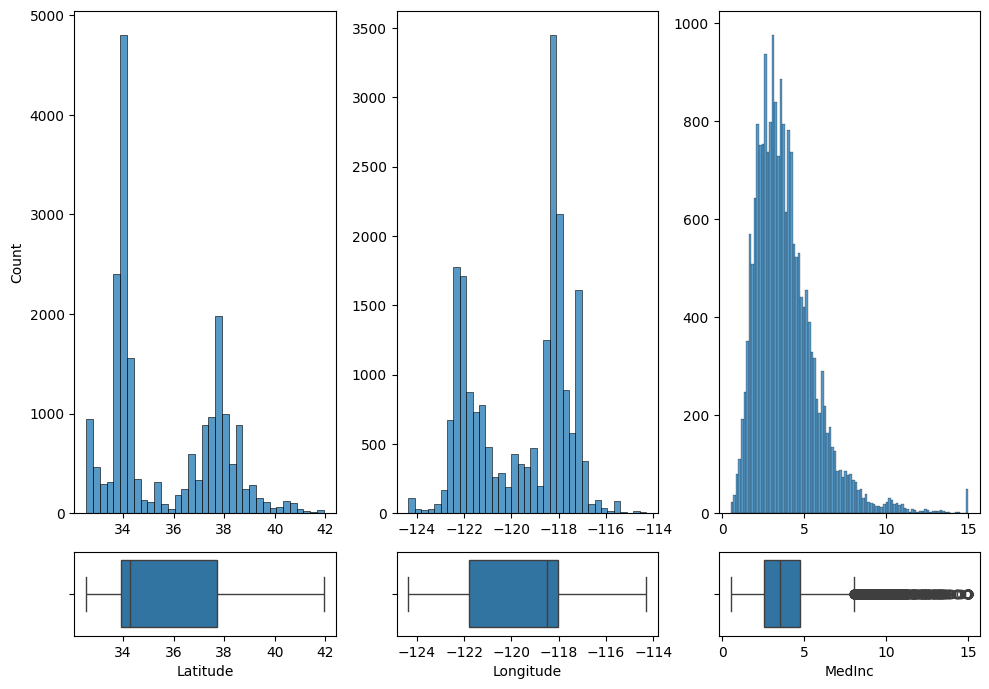

In [9]:
fig, axis = plt.subplots(2, 3, figsize = (10, 7), gridspec_kw={'height_ratios': [6, 1]})

sns.histplot(ax = axis[0, 0], data = df, x = "Latitude").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = df, x = "Latitude")
sns.histplot(ax = axis[0, 1], data = df, x = "Longitude").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = df, x = "Longitude")
sns.histplot(ax = axis[0, 2], data = df, x = "MedInc").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 2], data = df, x = "MedInc")

plt.tight_layout()

#### Key Findings:
Houses are not evenly distributed geographically, they cluster along certain lat/long bands.
Income has a skewed distribution, with most areas having modest income and a minority of high-income regions.

## Multivariate Analysis

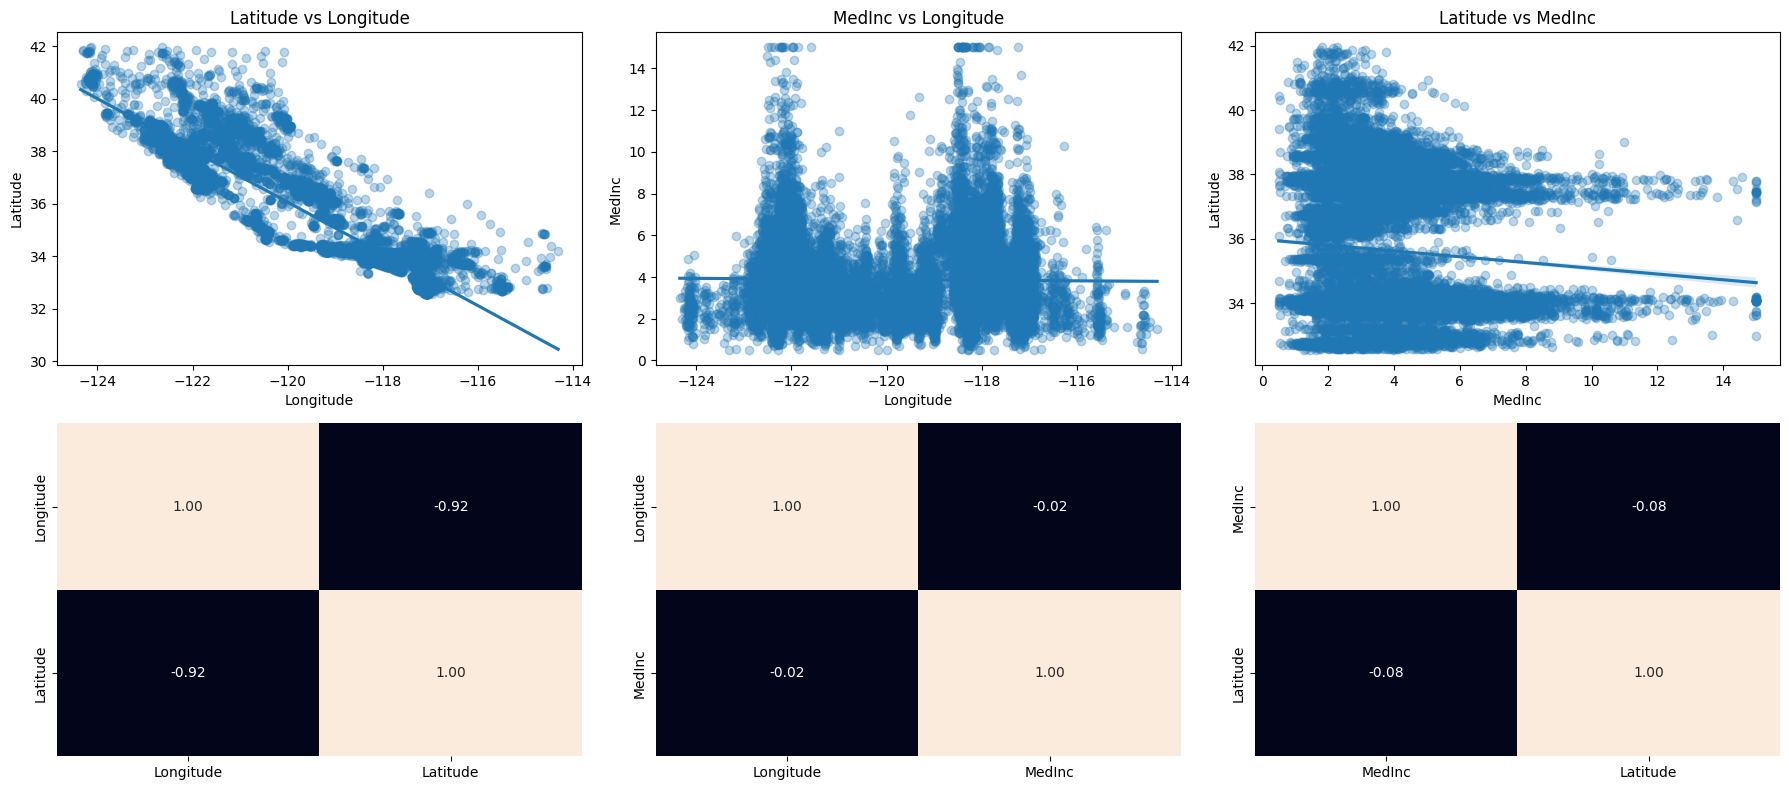

In [10]:
pairs = [("Longitude", "Latitude"),
         ("Longitude", "MedInc"),
         ("MedInc", "Latitude")]

fig, axes = plt.subplots(2,3,figsize=(18, 8))
for i, (a, b) in enumerate(pairs):
    # scatter plot
    sns.regplot(ax=axes[0, i], data=df, x=a, y=b, scatter_kws={'alpha':0.3})
    axes[0, i].set_title(f"{b} vs {a}")

    #correlation map
    corr = df[[a,b]].corr()
    sns.heatmap(corr, annot= True, fmt=".2f", ax=axes[1, i], cbar=False)

plt.tight_layout()
plt.show()

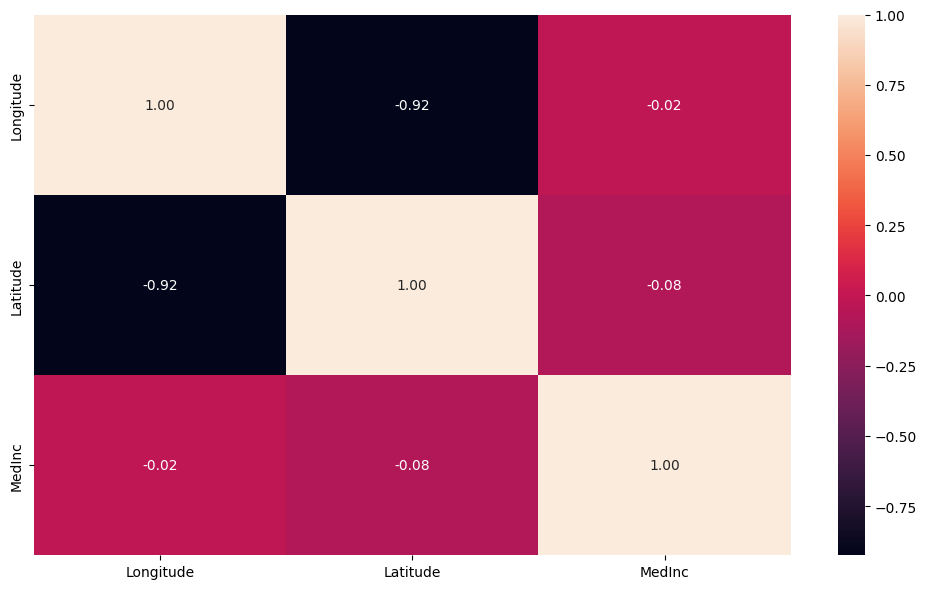

In [11]:
fig, axis = plt.subplots(figsize = (10, 6))

sns.heatmap(df[["Longitude", "Latitude", "MedInc"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

#### Key Findings: 
From the scatterplots and correlation analysis, we can see that latitude and longitude are very strongly and negatively correlated, as we move westward in longitude, latitude tends to decrease toward the south. In contrast, median income has almost no linear relationship with either longitude or latitude, as reflected in the very weak correlations. Overall, while the geographic variables are highly related to each other, median income adds might be an important socioeconomic variable that will contribute to the clustering process, ensuring that the groups reflect not only location but also differences in wealth.

## Splitting into train/test

In [18]:
X = df
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

X_train.head()

,Latitude,Longitude,MedInc
19985,36.20,-119.31,3.1453
11235,33.81,-117.96,5.2384
2271,36.78,-119.80,3.5542
8660,33.85,-118.39,4.3594
6250,34.04,-117.98,3.4722


## Scaling

In [20]:
scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## Train K-Means

In [27]:
# Training the model
model = KMeans(n_clusters = 6, random_state = 42)
model.fit(X_train_scale)
train_clusters = model.predict(X_train_scale)

# Saving the training clusters in our dataframe
df.loc[X_train.index, "cluster"] = train_clusters

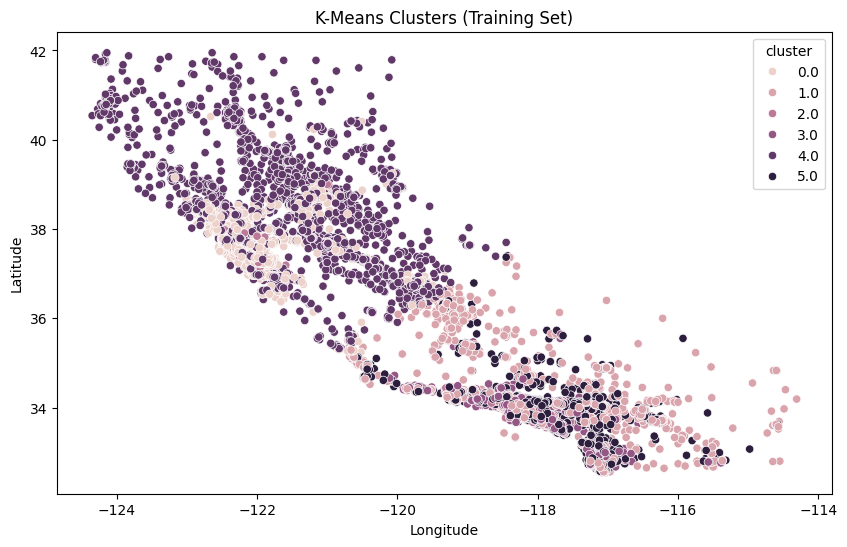

In [28]:
# Plotting a dot plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df.loc[X_train.index], 
    x="Longitude", 
    y="Latitude", 
    hue="cluster", 
)

plt.title("K-Means Clusters (Training Set)")
plt.show()

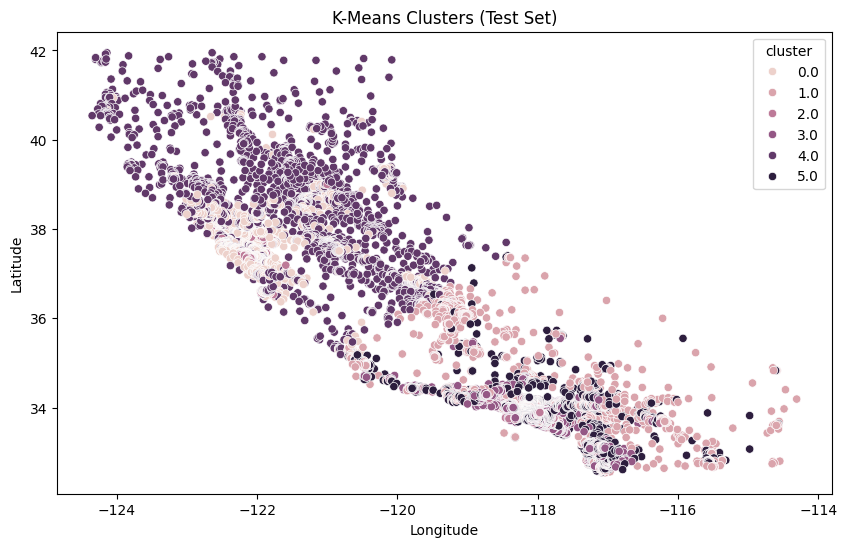

In [32]:
# Predict
test_clusters = model.predict(X_test_scale)
df.loc[X_test.index, "cluster"] = test_clusters

# Plotting

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="Longitude", 
    y="Latitude", 
    hue="cluster", 
)

plt.title("K-Means Clusters (Test Set)")
plt.show()

### KEy Findings:
After training K-Means with 6 clusters, the houses were grouped into distinct regions of California. The scatterplots show that the algorithm separates areas along geographic patterns, with clusters forming around major urban regions and along the coast. When applying the trained model to the test set, the new points aligned consistently with the training clusters, suggesting that the model works well with unseen data.

## Training a Supervised Classification model

### Trying Logistic Regression

In [40]:
X = df[["Latitude", "Longitude", "MedInc"]]
y = df["cluster"]

# Splitting
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model_log = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42)
model_log.fit(X_train_updated, y_train_updated)
y_pred = model_log.predict(X_test_updated)

print("Accuracy:", accuracy_score(y_test_updated, y_pred))
print("\nClassification Report:\n", classification_report(y_test_updated, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_updated, y_pred))

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9798885388902351

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       583
         1.0       0.98      0.98      0.98      1013
         2.0       0.98      0.98      0.98        65
         3.0       0.99      0.97      0.98       386
         4.0       0.97      0.99      0.98      1078
         5.0       0.98      0.99      0.98      1002

    accuracy                           0.98      4127
   macro avg       0.98      0.98      0.98      4127
weighted avg       0.98      0.98      0.98      4127


Confusion Matrix:
 [[ 564    0    0    0   16    3]
 [   0  988    0    0   17    8]
 [   1    0   64    0    0    0]
 [   2    0    1  375    0    8]
 [   4    4    0    0 1066    4]
 [   1   12    0    2    0  987]]


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Key Findings:
Logistic Regression achieved an accuracy of about 98%, with balanced precision and recall across all six clusters. This suggests that the clusters formed by K-Means are fairly well-separated in terms of latitude, longitude, and median income, making them easy to learn even with a linear model. Misclassifications were minimal and not concentrated in any particular cluster.

### Trying RandomForest

In [42]:
model_for = RandomForestClassifier(n_estimators=100, random_state=42)
model_for.fit(X_train_updated, y_train_updated)

y_pred_for = model_for.predict(X_test_updated)

print("Accuracy:", accuracy_score(y_test_updated, y_pred_for))
print("\nClassification Report:\n", classification_report(y_test_updated, y_pred_for))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_updated, y_pred_for))

Accuracy: 0.9963653985946208

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       583
         1.0       1.00      1.00      1.00      1013
         2.0       1.00      0.98      0.99        65
         3.0       1.00      1.00      1.00       386
         4.0       1.00      1.00      1.00      1078
         5.0       1.00      1.00      1.00      1002

    accuracy                           1.00      4127
   macro avg       1.00      0.99      1.00      4127
weighted avg       1.00      1.00      1.00      4127


Confusion Matrix:
 [[ 581    0    0    0    2    0]
 [   0 1008    0    0    1    4]
 [   0    0   64    1    0    0]
 [   0    0    0  386    0    0]
 [   2    1    0    0 1075    0]
 [   1    3    0    0    0  998]]


### Trying KNN

In [44]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_updated, y_train_updated)

y_pred_knn = model_knn.predict(X_test_updated)

# Evaluate
print("Accuracy:", accuracy_score(y_test_updated, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test_updated, y_pred_knn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_updated, y_pred_knn))

Accuracy: 0.9871577417009935

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       583
         1.0       0.98      0.99      0.99      1013
         2.0       0.98      0.98      0.98        65
         3.0       0.99      0.97      0.98       386
         4.0       0.99      0.99      0.99      1078
         5.0       0.98      0.98      0.98      1002

    accuracy                           0.99      4127
   macro avg       0.99      0.99      0.99      4127
weighted avg       0.99      0.99      0.99      4127


Confusion Matrix:
 [[ 579    0    0    0    4    0]
 [   0 1002    0    0    3    8]
 [   0    0   64    1    0    0]
 [   0    0    1  374    0   11]
 [   3    3    0    0 1072    0]
 [   1   16    0    1    1  983]]


#### Conclusions
I started by using Logistic Regression as a baseline model, which gave me an accuracy of about 98%. This shows that the clusters created by K-Means were already fairly easy to separate using the three features (Latitude, Longitude, and MedInc). Then I tested Random Forest, and the accuracy improved even further, reaching almost 100%. This model was clearly the best at handling the non-linear boundaries between clusters. Finally, I trained a KNN classifier, which also performed really well with almost 99% accuracy. This makes sense because KNN, like K-Means, is based on distances, so it fits naturally with the type of clusters we created. Overall, all three models performed strongly, but Random Forest gave the best results, while Logistic Regression provided a solid baseline and KNN connected directly with the distance-based nature of the clustering.

In [47]:
# SAving model
import joblib
import os

joblib.dump(model, "../models/kmeans_model.pkl")       
joblib.dump(model_knn, "../models/knn_model.pkl")            
joblib.dump(model_log, "../models/logreg_model.pkl")   
joblib.dump(model_for, "../models/randomforest_model.pkl")

['../models/randomforest_model.pkl']